In [1]:
import networkx as nx
import random
import numpy as np
import math 
import time
from copy import deepcopy
import matplotlib.pyplot as plt

# 不用轉換至 NetworkX 的方法
def get_one_network_result(N, round_num, neighbors_num):
    
    global b

    def f(nodes_set):   
        nonlocal all_nodes_set
        nonlocal revolt_nodes_record
        nonlocal round
        nonlocal neighbors
        nonlocal thresholds

        global b
        global start
        global break_time
        if (time.time() - start) > break_time: 
            b = True
            return set()  
    
        revolt_nodes = set()
        
        if (nodes_set == all_nodes_set) and (round >= 2):
            for n in revolt_nodes_record[round-2]:
                revolt_nodes.add(n)

        for n in nodes_set:
            if n not in revolt_nodes and b == False:
                if nodes_set.issubset(neighbors[n-1]):
                    if len(nodes_set) >= thresholds[n-1]:
                        revolt_nodes.add(n)
                else:
                    if len(g((nodes_set & neighbors[n-1]))) >= thresholds[n-1]:
                        revolt_nodes.add(n)
                    
        return revolt_nodes
    
    def g(nodes_set):
        
        global b
        global start
        global break_time
        if (time.time() - start) > break_time: 
            b = True
            return set()

        if len(nodes_set) == 1:
            return nodes_set
        else: 
            return f(nodes_set)

    # == 隨機產生 network (adjacent list) ==
    all_nodes_set = set(range(1, N+1))
    neighbors = []   
    for i in range(1, N+1):
        n = random.sample(list(all_nodes_set-{i}), neighbors_num)
        neighbors.append({i, *n})
    neighbors_at_t1 = deepcopy(neighbors)

    thresholds = []
    for i in range(1, N+1, 2):
        thresholds.append(int(i/2)+1)
        thresholds.append(int(i/2)+1)
        
    # print(all_nodes_set, neighbors, thresholds)
    # print(neighbors)

    # == 開始找出各個時間點(t)誰會revolt ==
    round = 1
    revolt_nodes_num = []
    revolt_nodes_record = []
    for i in range(round_num):
        if round != 1:
            # 讓自己所有 neighbor 的 neighbors，成為自己的 neighbor
            for i in range(1, N+1):
                for n in neighbors[i-1]:
                    if n != i:            
                        neighbors[i-1] = (neighbors[i-1] | neighbors_at_t1[n-1])
        revolt_nodes = g(all_nodes_set) 
        
        revolt_nodes_num.append(len(revolt_nodes))
        revolt_nodes_record.append(revolt_nodes)
        round += 1

        if b == True:
            break

    revolt_nodes_record = [list(s) for s in revolt_nodes_record]
    return revolt_nodes_num, revolt_nodes_record

# Part 1.

In [2]:
random.seed(6)
N = 30
neighbors_num = 2
round_num = 8
break_time = 60 # (second)

records1 = []
records2 = []

# network_num = 3
# for network in range(network_num):
#     print(network+1, end = " ")
#     start = time.time()
#     b = False
#     revolt_nodes_num, revolt_nodes_record = get_one_network_result(N, round_num, neighbors_num)
#     if b == False:
#         records1.append(revolt_nodes_num)
#         records2.append(revolt_nodes_record)

all_start = time.time()
network_num = 0
while network_num < 1000: # set number of networks here!
    start = time.time()
    b = False
    revolt_nodes_num, revolt_nodes_record = get_one_network_result(N, round_num, neighbors_num)
    if b == False:
        records1.append(revolt_nodes_num)
        records2.append(revolt_nodes_record)
        network_num += 1   
        # if network_num % 10 == 0: print(network_num, end = " ")
        
print("\nNumber of networks:", len(records1))
print("Running time:", time.strftime("%H:%M:%S", time.gmtime(time.time()-all_start)))


Number of networks: 1000
Running time: 08:59:28


In [3]:
textfile = open("records1.txt", "w")
for n in records1:
    for r in n:
        textfile.write(str(r)+" ")
    textfile.write("\n")
textfile.close()

textfile = open("records2.txt", "w")
for n in records2:
    for r in n:
        textfile.write(str(r)+" ")
    textfile.write("\n")
textfile.close()

## FIG. 5.

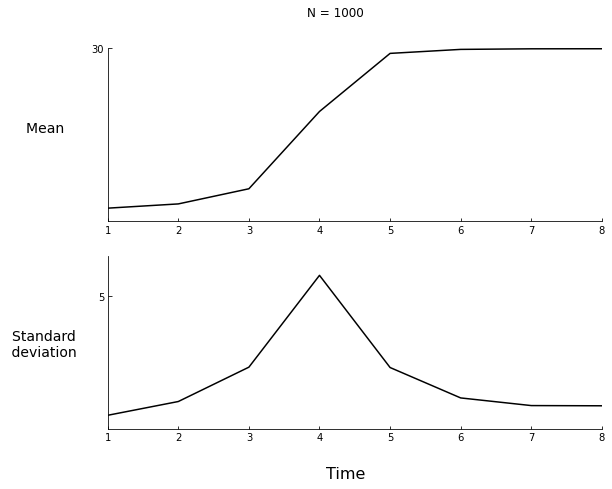

In [4]:
data = np.matrix(records1)
mean = np.array(np.mean(data, axis=0)).flatten()
sd = np.array(np.std(data, axis=0)).flatten()
x = list(range(1, round_num+1))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
ratio = 0.35

ax1.plot(x, mean, color='black')
ax2.plot(x, sd, color='black')

ax1.tick_params(direction="in")
ax1.set_ylim(0, 30)
ax1.set_yticks(np.array([30]))
ax1.set_xlim(1, 8)
xleft, xright = ax1.get_xlim()
ybottom, ytop = ax1.get_ylim()
ax1.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Mean                   ", rotation=0, y=0.5, fontsize=14)

ax2.tick_params(direction="in")
ax2.set_ylim(0, 6.5)
ax2.set_yticks(np.array([5]))
ax2.set_xlim(1, 8)
xleft, xright = ax2.get_xlim()
ybottom, ytop = ax2.get_ylim()
ax2.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("Standard                      \n deviation                       ", rotation=0, y=0.4, fontsize=14)

fig.set_facecolor('white')
plt.title("N = "+str(len(records1)), x=0.46, y=2.35)
plt.suptitle("Time", y=0.05, fontsize=16)
plt.savefig('FIG5.jpg')
plt.show()

## FIG. 6.

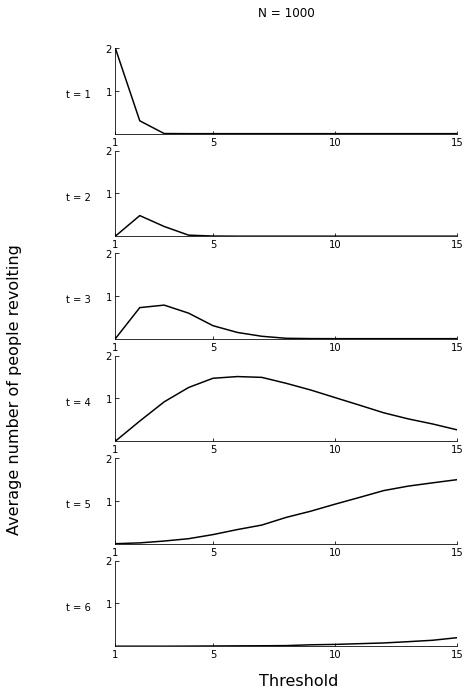

In [5]:
records2_first = deepcopy(records2)
for n, network in enumerate(records2):
    for round, revolter in enumerate(network, 1):
        if round != 1:
            records2_first[n][round-1] = set(revolter) - last_revolter
        last_revolter = set(revolter)


fig, (ax1, ax2, ax3, ax4, ax5, ax6)  = plt.subplots(6, 1, figsize=(10, 11))
x = list(range(1, 16))

round = 1
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    y = [0 for i in range(15)]
    for network in records2_first:
        for node in network[round-1]:
            y[math.ceil(node/2)-1] += 1
    y = [i/len(records2) for i in y]
    ax.plot(x, y, color='black')

    ax.tick_params(direction="in")
    ax.set_ylim(0, 2)
    ax.set_yticks(np.array([1, 2]))
    ax.set_xlim(1, 15)
    ax.set_xticks(np.array([1, 5, 10, 15]))
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*0.25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("t = "+str(round)+"               ", rotation=0, y=0.4)

    round += 1

fig.set_facecolor('white')
fig.text(0.125, 0.45, 'Average number of people revolting', va='center', rotation='vertical', fontsize=16)
fig.text(0.475, 0.075, 'Threshold', fontsize=16)
plt.title("N = "+str(len(records1)), x=0.5, y=7.3)
plt.savefig('FIG6.jpg')
plt.show()

## FIG. 7. 

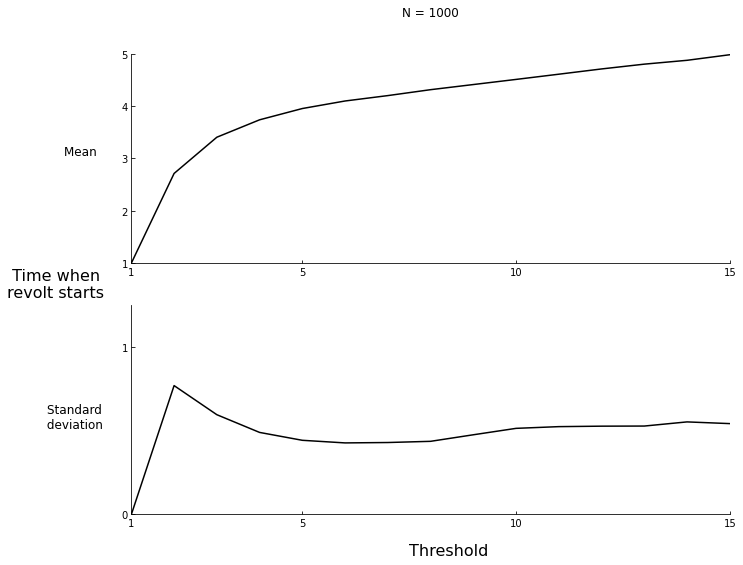

In [6]:
revolt_round = []
for network in records2_first:
    r = [0 for i in range(15)]
    for round in range(round_num):
        for node in network[round]:
            r[math.ceil(node/2)-1] += round+1 
    r = [i/2 for i in r]
    revolt_round.append(r)
            
data = np.matrix(revolt_round)
mean = np.array(np.mean(data, axis=0)).flatten()
sd = np.array(np.std(data, axis=0)).flatten()
x = list(range(1, len(revolt_round[0])+1))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ratio = 0.35

ax1.plot(x, mean, color='black')
ax2.plot(x, sd, color='black')

ax1.tick_params(direction="in")
ax1.set_ylim(1, 5)
ax1.set_yticks(np.array([1, 2, 3, 4, 5]))
ax1.set_xlim(1, 15)
ax1.set_xticks(np.array([1, 5, 10, 15]))
xleft, xright = ax1.get_xlim()
ybottom, ytop = ax1.get_ylim()
ax1.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Mean                   ", rotation=0, y=0.5, fontsize=12)

ax2.tick_params(direction="in")
ax2.set_ylim(0, 1.25)
ax2.set_yticks(np.array([0, 1]))
ax2.set_xlim(1, 15)
ax2.set_xticks(np.array([1, 5, 10, 15]))
xleft, xright = ax2.get_xlim()
ybottom, ytop = ax2.get_ylim()
ax2.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("Standard                      \n deviation                       ", rotation=0, y=0.4, fontsize=12)

fig.set_facecolor('white')
fig.text(0.01, 0.5, ' Time when\nrevolt starts', va='center', fontsize=16)
fig.text(0.475, 0.03, 'Threshold', fontsize=16)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.title("N = "+str(len(records1)), x=0.5, y=2.35)
plt.savefig('FIG7.jpg')
plt.show()